<a href="https://colab.research.google.com/github/pycroscopy/atomai/blob/master/examples/notebooks/GraphAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning and graph analysis of atomically resolved images

Example of combining deep learning and graph analysis via [AtomAI](https://github.com/pycroscopy/atomai) package for identifying topological defects in graphene.

---


*  *Notebook prepared by Maxim Ziatdinov*

*  *Experimental data by Ondrej Dyck*

*  *Deep learning model was trained by Maxim Ziatdinov using MD calculations by Bobby Sumpter and Ayana Ghosh*

---





Install AtomAI:

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Imports:

In [2]:
import atomai as aoi
from atomai.utils import graphx

import numpy as np
import matplotlib.pyplot as plt

Download data and pre-trained model. The experimental data on graphene was collected by Ondrej Dyck. The model was trained by Maxim Ziatdinov using DFT-MD simulations by Bobby Sumpter.

In [3]:
# download data
!gdown "https://drive.google.com/uc?id=18U8YHZUbSZj0Q1__zup5-ABrjaEZmiPc"
# download model
!gdown "https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M"

Downloading...
From: https://drive.google.com/uc?id=18U8YHZUbSZj0Q1__zup5-ABrjaEZmiPc
To: /content/Gr_SiCr.npy
4.19MB [00:00, 66.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M
To: /content/G_MD.tar
11.1MB [00:00, 67.8MB/s]


Load data and model into the notebook:

In [4]:
imgdata = np.load("Gr_SiCr.npy")
model = aoi.load_model("G_MD.tar")

Plot experimental data:

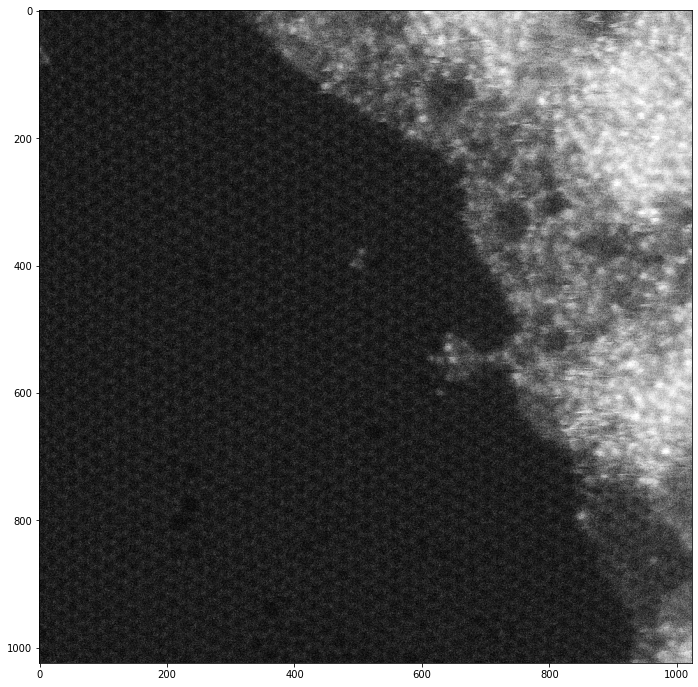

In [5]:
plt.figure(figsize=(12, 12))
plt.imshow(imgdata, cmap="gray")

We next use the pre-trained model to extract atomic coordinates. Note that since our MD simulations were performed only for pure graphene system (no dopants/impurities), the model categorizes all atoms as one class. This model can be further improved and even extended to multiple classes via iterative (re-)training using "good" portions of the experimental data. Keep in mind that there is an optimal pixel-to-angstrom ratio (number of pixels per atom) for which the pre-trained model has an optimal performance. For this model, it is around 0.1. You can set your predictor to resize all the input images to a specific size *if necessary* by passing ```resize``` argument, that is, ```model.predict(imgdata, resize=(new_height, new_width))```.

In [6]:
nn_out, coords = model.predict(imgdata)

Batch 1/1
1 image was decoded in approximately 0.2377 seconds


Now let's find graphene rings of specific shape (e.g. 5-member rings, 7-member rings, 5+7 member rings, etc.). Here we need to specify a dictionary that will map classes from the model's output into chemical elements. As noted earlier, this particular model doesn't differentiate between different atomic species, but we still added Si to dictionary just as an example (it will be ignored). We also need to specify a coefficient for converting from pixel coordinates to coordiantes in angstroms. *This is very important because we use information about actual atomic covalent radius to construct graphs.* In future, once we stadardize our data format using [pyNSID](https://github.com/pycroscopy/pyNSID), we  will be reading it from metadata, but for now you need to specify it manually. Please also keep in mind that there is usually an optimal pixel-to-angstrom ratio (number of pixels per atom) for which any pre-trained model has an optimal performance.

In [7]:
map_dict = {0: "C", 1: "Si"}  # classes to chemical elements
px2ang = 0.104 # pixel-to-angstrom conversion 
coord = coords[0] # take the first (and the only one) frame

Find rings of interest (e.g. all 5-member rings for the current image):

In [8]:
clusters = graphx.find_cycle_clusters(
    coord, cycles=5, map_dict=map_dict, px2ang=px2ang)

The output is a list of numpy arrays with coordinates of "clusters" of connected rings. We can easily identify center of the mass for each cluster by computing *mean(x)* and *mean(y)* of all atomic coordiantes in this cluster.

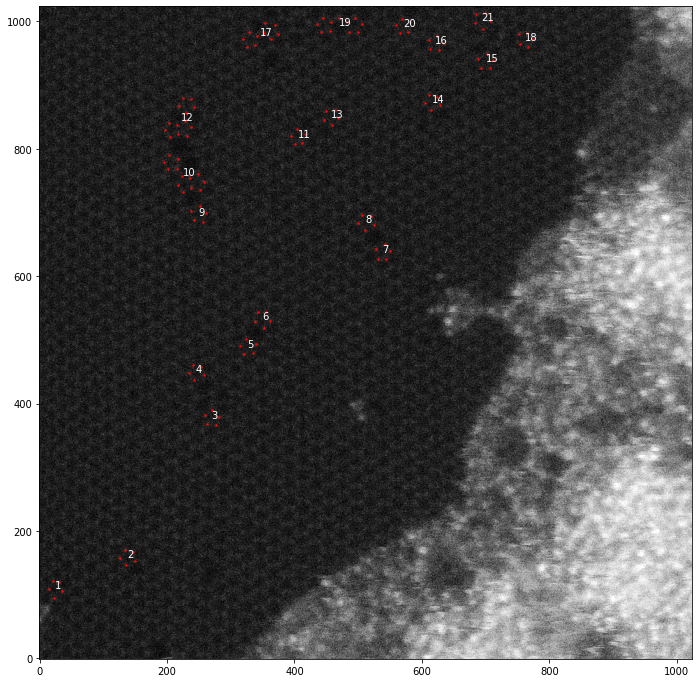

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(imgdata, cmap='gray', origin='lower')
for i, cl in enumerate(clusters):
    ax.scatter(cl[:, 1], cl[:, 0], s=2, color='red')
    xt = int(np.mean(cl[:, 1]))
    yt = int(np.mean(cl[:, 0]))
    ax.annotate(str(i+1), (xt, yt), size=10, color='white')

Now do the same for all 7-member rings:

In [10]:
clusters = graphx.find_cycle_clusters(
    coord, cycles=7, map_dict=map_dict, px2ang=px2ang)

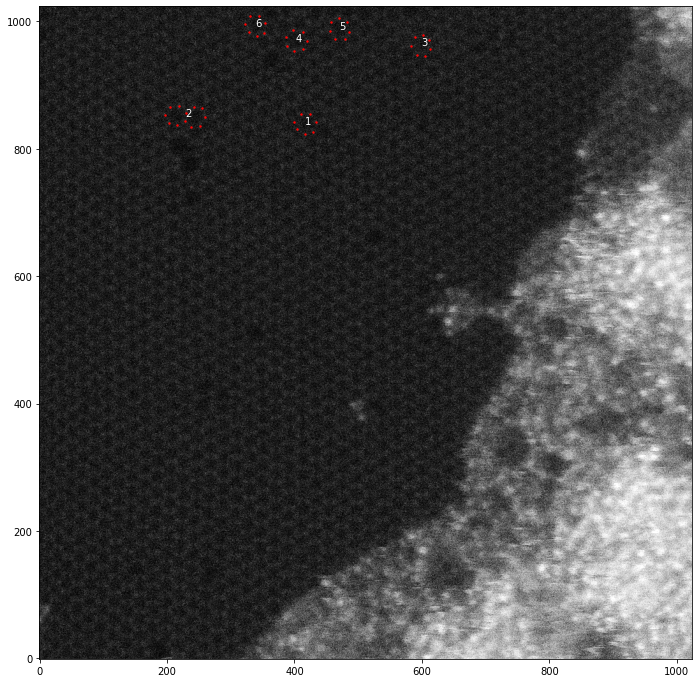

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(imgdata, cmap='gray', origin='lower')
for i, cl in enumerate(clusters):
    ax.scatter(cl[:, 1], cl[:, 0], s=2, color='red')
    xt = int(np.mean(cl[:, 1]))
    yt = int(np.mean(cl[:, 0]))
    ax.annotate(str(i+1), (xt, yt), size=10, color='white')

We can also pass multiple ring sizes:

In [12]:
clusters = graphx.find_cycle_clusters(
    coord, cycles=[5, 7, 8], map_dict=map_dict, px2ang=px2ang)

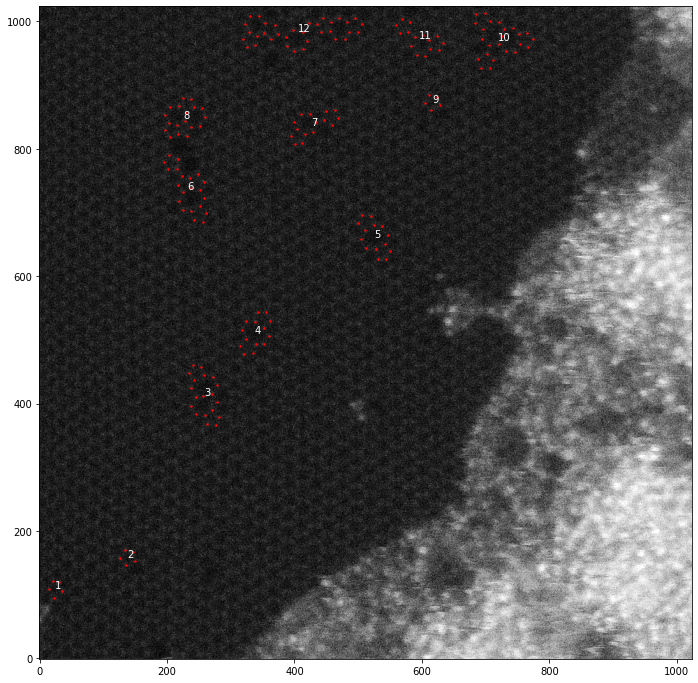

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(imgdata, cmap='gray', origin='lower')
for i, cl in enumerate(clusters):
    ax.scatter(cl[:, 1], cl[:, 0], s=2, color='red')
    xt = int(np.mean(cl[:, 1]))
    yt = int(np.mean(cl[:, 0]))
    ax.annotate(str(i+1), (xt, yt), size=10, color='white')